In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from random import random

import os,sys

import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import datetime as dt


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.seasonal import seasonal_decompose
from itertools import product
from datetime import datetime, timedelta

import warnings

In [2]:
# Inverse Box-Cox Transformation Function
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

In [3]:
fdir = os.path.join(sys.path[0],"data/")
flist = os.listdir(fdir)
DataSet = {}
for file in flist:
    # print(file)
    Coinname = file.replace("coin_", "", 1).replace(".csv","",1)
    # print(Coinname)
    DataSet[Coinname] = pd.read_csv("data/"+file).set_index("Date")
    DataSet[Coinname].index = pd.to_datetime(DataSet[Coinname].index)
    DataSet[Coinname].sort_index(inplace=True)

In [4]:
for key in DataSet:
    print(key)

Aave
BinanceCoin
Bitcoin
Cardano
ChainLink
Cosmos
CryptocomCoin
Dogecoin
EOS
Ethereum
Iota
Litecoin
Monero
NEM
Polkadot
Solana
Stellar
Tether
Tron
Uniswap
USDCoin
WrappedBitcoin
XRP


In [5]:
coin = "Bitcoin"
df = DataSet[coin][['Close']]
print(df.head(3))
print(df.tail(3))

                          Close
Date                           
2013-04-29 23:59:59  144.539993
2013-04-30 23:59:59  139.000000
2013-05-01 23:59:59  116.989998
                            Close
Date                             
2021-02-25 23:59:59  47093.853019
2021-02-26 23:59:59  46339.760083
2021-02-27 23:59:59  46188.451275


<AxesSubplot:xlabel='Date'>

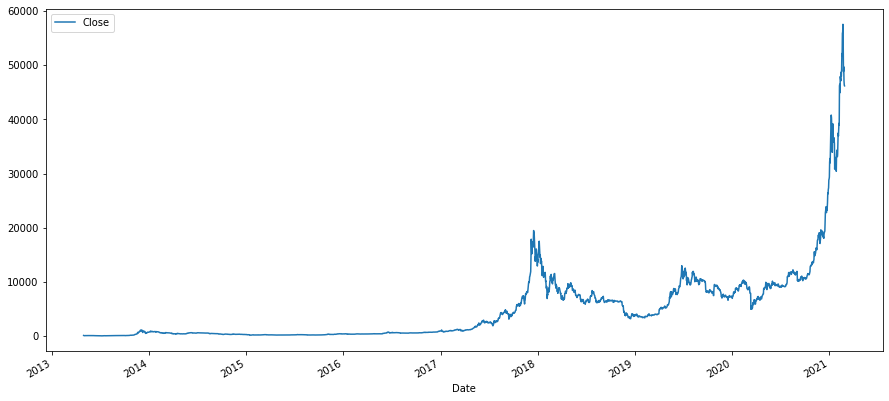

In [6]:
df.plot()

In [7]:
dfMonth = DataSet[coin].drop(columns=["SNo","Name","Symbol"])
dfMonth = dfMonth.resample('M').mean()

Dickey–Fuller test: p=0.998919


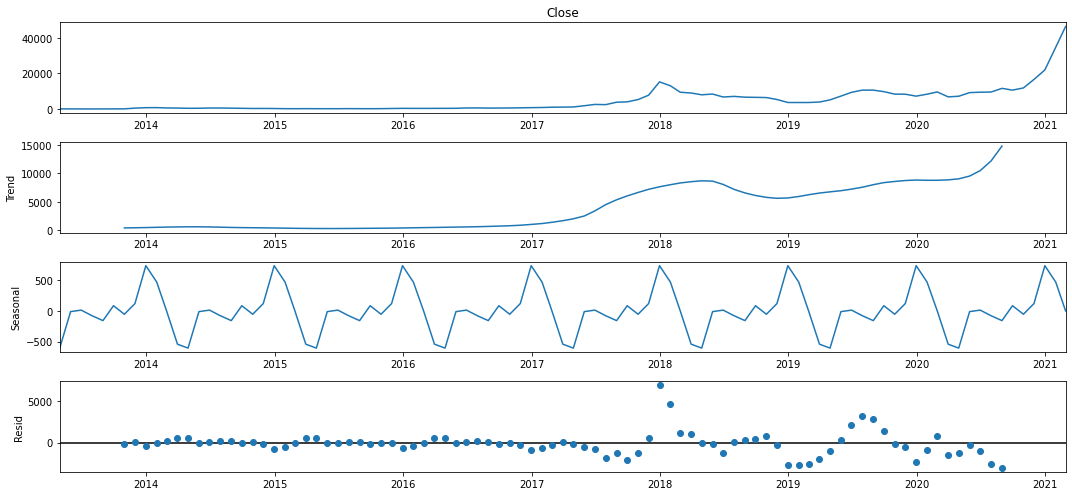

In [8]:
seasonal_decompose(dfMonth.Close).plot()
print("Dickey–Fuller test: p=%f" % adfuller(dfMonth.Close)[1])
plt.show()

In [9]:
dfMonth['Close_box'], lmbda = stats.boxcox(dfMonth.Close)
print("Dickey–Fuller test: p=%f" % adfuller(dfMonth.Close_box)[1])

# # Seasonal differentiation (12 months)
# dfMonth['box_diff_seasonal_12'] = dfMonth.Close_box - dfMonth.Close_box.shift(12)
# print("Dickey–Fuller test: p=%f" % adfuller(dfMonth.box_diff_seasonal_12[12:])[1])

# dfMonth['box_diff_seasonal_3'] = dfMonth.Close_box - dfMonth.Close_box.shift(3)
# print("Dickey–Fuller test: p=%f" % adfuller(dfMonth.box_diff_seasonal_3[3:])[1])

# dfMonth['box_diff2'] = dfMonth.box_diff_seasonal_12 - dfMonth.box_diff_seasonal_12.shift(1)

# # STL-decomposition
# seasonal_decompose(dfMonth.box_diff2[13:]).plot()   
# print("Dickey–Fuller test: p=%f" % adfuller(dfMonth.box_diff2[13:])[1])
# plt.show()

Dickey–Fuller test: p=0.856255


In [10]:
# Initial approximation of parameters
qs = range(0, 3)
ps = range(0, 3)
d=1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        model = SARIMAX(dfMonth.Close_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

  parameters        aic
3     (1, 0) -26.579614
1     (0, 1) -25.228748
4     (1, 1) -24.607245
6     (2, 0) -24.599110
7     (2, 1) -24.141584
                               SARIMAX Results                                
Dep. Variable:              Close_box   No. Observations:                   95
Model:               SARIMAX(1, 1, 0)   Log Likelihood                  15.290
Date:                Wed, 26 May 2021   AIC                            -26.580
Time:                        10:51:05   BIC                            -21.493
Sample:                    04-30-2013   HQIC                           -24.525
                         - 02-28-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4093      0.101      4.038      0.000       0.211

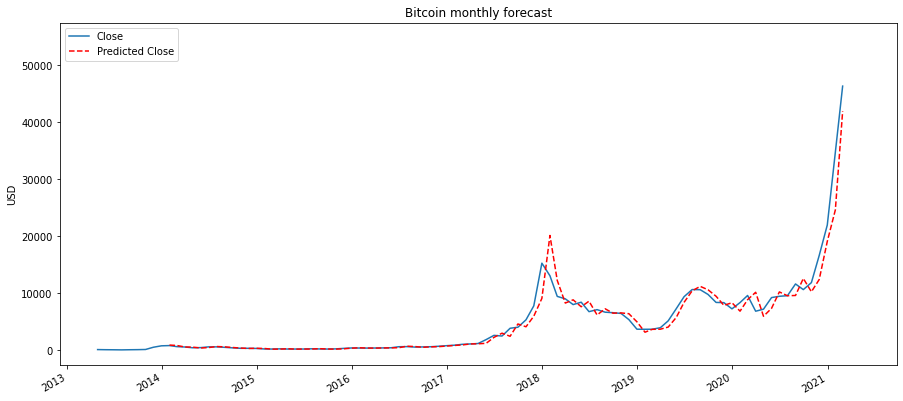

In [11]:
# Prediction
df_month_pred = dfMonth[['Close']]

date_list = [datetime(2021,3,30),datetime(2021,4,30)]
future = pd.DataFrame(index=date_list, columns= dfMonth.columns)
df_month_pred = pd.concat([df_month_pred, future])

df_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2014, 1, 31), end=datetime.now()), lmbda)


plt.figure(figsize=(15,7))
df_month_pred.Close.plot()
df_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title(f"{coin} monthly forecast")
plt.ylabel('USD')
plt.show()

In [12]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")

for param in parameters_list:
    try:
        model = SARIMAX(dfMonth.Close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [13]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())
print("Dickey–Fuller test:: p=%f" % adfuller(best_model.resid[13:])[1])

      parameters        aic
19  (1, 0, 0, 1) -10.708848
7   (0, 1, 0, 1) -10.117279
21  (1, 0, 1, 1)  -9.023386
25  (1, 1, 0, 1)  -8.810391
37  (2, 0, 0, 1)  -8.788393
                                      SARIMAX Results                                      
Dep. Variable:                           Close_box   No. Observations:                   95
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 4)   Log Likelihood                   8.354
Date:                             Wed, 26 May 2021   AIC                            -10.709
Time:                                     10:51:20   BIC                             -3.209
Sample:                                 04-30-2013   HQIC                            -7.685
                                      - 02-28-2021                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------

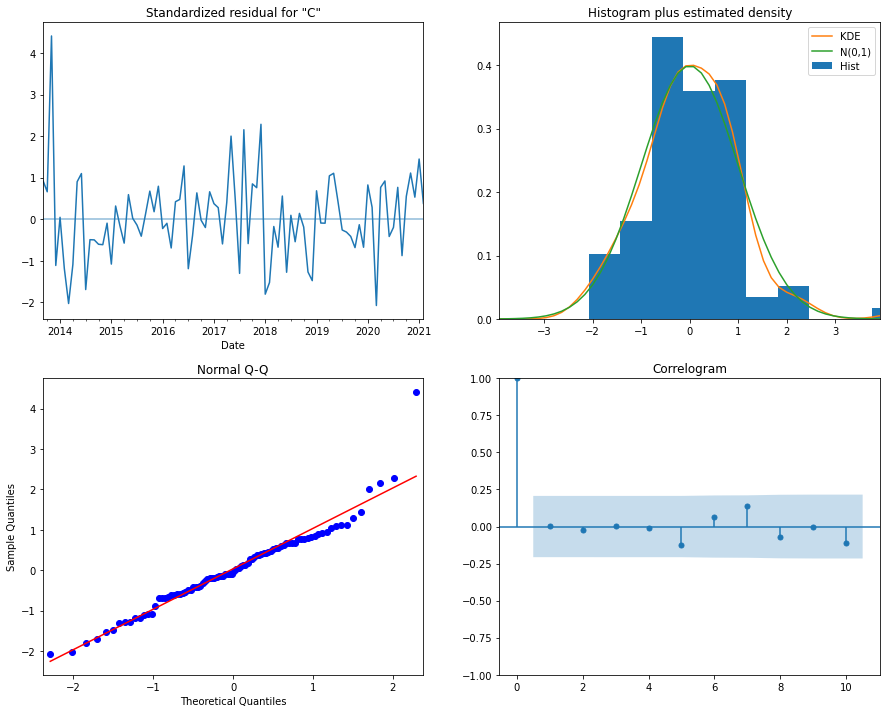

In [14]:
best_model.plot_diagnostics(figsize=(15, 12))
plt.show()

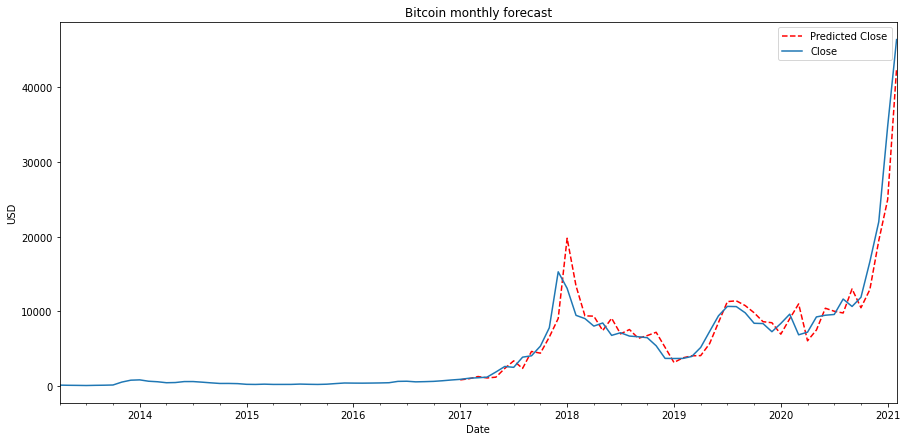

In [25]:
# Prediction
crypto_month_pred = dfMonth[['Close']]

# date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
# future = pd.DataFrame(index=date_list, columns= dfMonth.columns)
# btc_month_pred = pd.concat([btc_month_pred, future])

crypto_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2017, 1, 31), end=datetime.now()), lmbda)

plt.figure(figsize=(15,7))

crypto_month_pred.Close.plot()
crypto_month_pred.forecast.plot(color='r', ls='--', label='Predicted Close')
plt.legend()
plt.title(f"{coin} monthly forecast")
plt.ylabel('USD')
plt.show()

In [16]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
#        model = SARIMAX(btc_month.close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        model = SARIMAX(dfMonth.Close_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        print('bad parameter combination:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

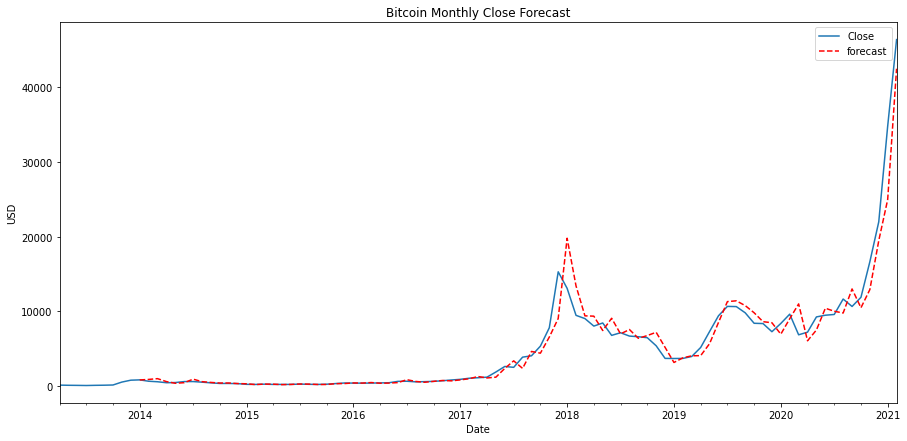

In [18]:
# Prediction
crypto_month2 = dfMonth[['Close']]
# date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
# future = pd.DataFrame(index=date_list, columns= dfMonth.columns)
# crypto_month2 = pd.concat([crypto_month2, future])

crypto_month2['forecast'] = invboxcox(best_model.predict(start = datetime(2014, 1, 31), end=datetime.now()), lmbda)

plt.figure(figsize=(15,7))
crypto_month2.Close.plot()
crypto_month2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title(f"{coin} Monthly Close Forecast")
plt.ylabel('USD')
plt.savefig(f"{coin}_monthly_forecast.png")
plt.show()

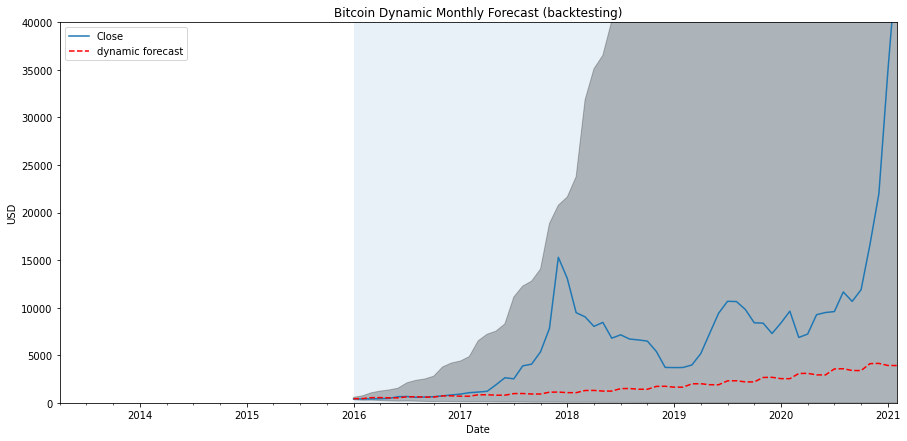

In [24]:
# Get the dynamic forecast between dates t1 and t2
t1 = pd.to_datetime('2016-01-31')
t2 = pd.to_datetime('2021-04-30')
crypto_month_dynamic = best_model.get_prediction(start=t1, end=t2, dynamic=True, full_results=True)
crypto_month2['dynamic_forecast'] = invboxcox(crypto_month_dynamic.predicted_mean, lmbda)

# Taking 80% confidence interval because the 95% blows out too high to visualise
pred_dynamic_ci = crypto_month_dynamic.conf_int(alpha=0.2)
pred_dynamic_ci['lower Close_box'] = invboxcox(pred_dynamic_ci['lower Close_box'], lmbda)
pred_dynamic_ci['upper Close_box'] = invboxcox(pred_dynamic_ci['upper Close_box'], lmbda)

# Plot
plt.figure(figsize=(15,7))
plt.ylim((0,40000))

crypto_month2.Close['2016':'2021-04'].plot(label='Close')
crypto_month2.dynamic_forecast.plot(color='r', ls='--', label='dynamic forecast')

plt.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
plt.fill_betweenx(plt.ylim(), t1, t2, alpha=.1, zorder=-1)

plt.legend()
plt.title(f"{coin} Dynamic Monthly Forecast (backtesting)")
plt.ylabel('USD')
plt.show()

In [20]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf


In [21]:
df.index[-1]

Timestamp('2021-02-27 23:59:59')